In [1]:
import numpy as np
import pandas as pd
import re, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

import sys
sys.path.append("..")
import time
from huginn.demo_console import demo_console

In [2]:
cl = demo_console()

keyword: Facebook
[{'mid': '/m/02y1vz', 'title': 'Facebook', 'type': 'Social networking service'}, {'mid': '/m/0hmyfsv', 'title': 'Facebook', 'type': 'Social media company'}, {'mid': '/m/0k2ljgx', 'title': 'Facebook Messenger', 'type': 'Topic'}, {'mid': '/m/0crj9_l', 'title': 'Face book', 'type': 'Topic'}, {'mid': '/g/11c5h24bx2', 'title': 'Facebook', 'type': 'Topic'}]
Enter the mid you are interested in: /m/02y1vz


In [13]:
cl.get_anomalies(k = 2.5, halflife_std = 10, halflife_mean = 1)

DatetimeIndex(['2007-09-01', '2007-10-01', '2008-05-01', '2008-10-01',
               '2008-11-01', '2008-12-01', '2009-09-01'],
              dtype='datetime64[ns]', name='date', freq=None)

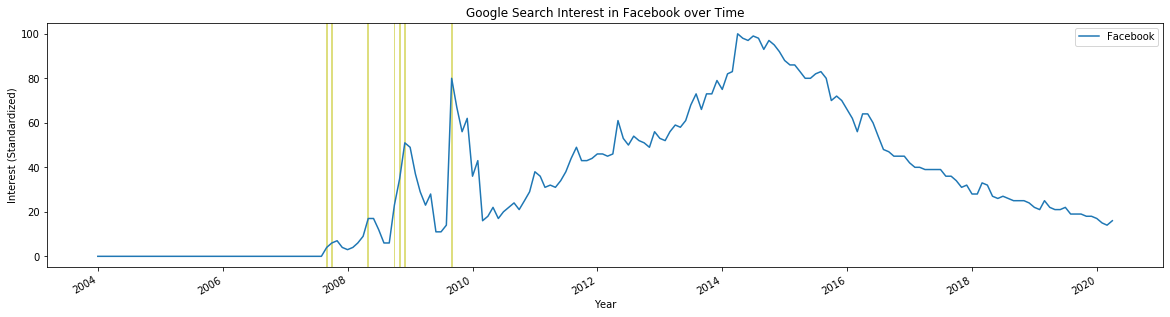


        If you are not happy with these anomalies, you can call the method 'get_anomalies' and
        specify the function to get anomalies:
        - method = 'constant' with parameter k (set to 1 by default)
        - method = 'rolling' with parameters lookback_mean, lookback_std and k (set to 1, 10, 1 by default)
        - method = 'ewm' with parameters halflife_mean, halflife_std and k(set to 1,10,1 by default) [default method]
        


In [14]:
cl.plot_interest_with_anomalies()

In [15]:
cl.get_info(num_links = 10)

You asked for 70 articles.
70 articles about Facebook were found.
82% of found articles could have been scrapped


In [16]:
print(dir(cl))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'anomalies', 'anomalies_formatted', 'anomaly_plot', 'articles', 'check_got_anomalies', 'check_got_articles', 'check_got_ldamodel', 'get_anomalies', 'get_info', 'get_summary', 'gpt2', 'images', 'interest', 'mid', 'model_lda', 'name', 'plot_interest', 'plot_interest_with_anomalies', 'titles', 'urls']


In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = {}
for date in cl.articles.keys():
    data[date] = list(sent_to_words(cl.articles[date]))

In [19]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
for date in cl.articles.keys():
    data[date] = lemmatization(data[date], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [20]:
vectorizer = CountVectorizer(analyzer='word',               
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num chars > 3

for date in cl.articles.keys():
    data[date] = vectorizer.fit_transform(data[date])

In [23]:
best_model = {}
for date in cl.articles.keys():
    # Define Search Param
    search_params = {'n_components': [1,2,3,4], 'learning_decay': [.5,0.7,0.9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(data[date])
    
    # Best Model
    best_lda_model = model.best_estimator_
    
    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)

    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(data[date]))
    
    best_model[date] = best_lda_model

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -5159.138260066275
Model Perplexity:  914.6238208775364
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -5240.682627107225
Model Perplexity:  737.5473505838148
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -6085.487399461463
Model Perplexity:  1250.6291665361034
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -4736.183537942059
Model Perplexity:  932.7138739003794
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -4818.11266008365
Model Perplexity:  1021.4857040519797
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -3668.8899747279856
Model Perplexity:  725.6842421497954
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -4039.51274

In [35]:
dic_df_document_topic = {}

for date in cl.articles.keys():
    # Create Document - Topic Matrix
    lda_output = best_model[date].transform(data[date])

    # column names
    topicnames = ["Topic" + str(i) for i in range(best_model[date].n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(data[date].shape[0])]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(lda_output, columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    dic_df_document_topic[date] = df_document_topic.round(2)

In [36]:
dic_df_topic_distribution = {}
for date in cl.articles.keys():
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    dic_df_topic_distribution[date] = df_topic_distribution

In [32]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

ValueError: Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required.

In [33]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,aborted,abruptly,absolutely,abuse,accelerate,accident,accidentally,accommodate,...,wrinkle,write,writer,writing,wrong,year,yearbook,yearn,yesterday,young
Topic0,6.0,4.0,2.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,...,2.0,31.0,14.0,3.0,2.0,21.0,2.0,2.0,2.0,2.0


In [35]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,say,apple,price,phone,iphone,fake,write,company,make,job,store,lyon,month,cut,year


In [37]:
dominant_topic = 0
ids = list(map(lambda x : int(x[3:]), list(
                    df_document_topic[df_document_topic['dominant_topic']==dominant_topic].index)))
data_to_summarize = [articles[i] for i in ids]
len(data_to_summarize)

9

In [38]:
from transformers import pipeline

def run_summary(gpt2_input):
    text_to_summarize = ''.join(gpt2_input)
    summarizer = pipeline("summarization")
    return summarizer(text_to_summarize)

for date in cl.articles.keys():
    print(date,run_summary(cl.articles[date]))

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2007-09-01 00:00:00 [{'summary_text': 'Microsoft, Google and several funds are considering investments in Facebook. Microsoft is considering an investment of $300 million to $500 million for a 5 percent stake. Google is also said to be interested in an investment. Facebook is seeking a minimum valuation of $10 billion but could go as high as $13 billion.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2007-10-01 00:00:00 [{'summary_text': 'An alliance of companies led by Google plans to begin introducing a common set of standards. The strategy is aimed at one-upping Facebook, which last spring opened its service to outside developers. More than 5,000 small programs have been built to run on the Facebook site. For Google, the effort could breathe new life into Orkut.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-05-01 00:00:00 [{'summary_text': 'Wen Jiabao has a page on Facebook, one of the most popular sites of its kind. As of early Wednesday, the page had about 13,000 “supporters” It reflects the booming popularity of Mr. Wen, also known as “Grandpa Wen,’ who flew to Sichuan.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-10-01 00:00:00 [{'summary_text': 'Facebook is used as a vehicle for nostalgia. There are thousands of alumni associations that provide a virtual, perpetual reunion. For current Park Slopers, the site captures the unusual experience of childhood. Some use the group to settle old scores that reflect a landscape hard to imagine now.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-11-01 00:00:00 [{'summary_text': 'Facebook Connect allows members to log onto other Web sites using their Facebook ID. Members can see their friends’ activities on those sites. Connect also gives members the opportunity to broadcast their actions to friends on Facebook. In the next few weeks, a number of prominent Web sites will weave this service into their pages.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-12-01 00:00:00 [{'summary_text': 'Thousands of users join fan pages devoted to top Mafia bosses on Facebook. Facebook Connect allows its members to log onto other Web sites using their Facebook ID. Connect also gives members the opportunity to broadcast their actions on those sites to their friends. Facebook wants to make certain the other Web companies do not supplant it.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2009-09-01 00:00:00 [{'summary_text': 'Facebook has been slowly introducing features that mimic Twitter. Users can now “tag” friends or companies that they mention in status updates. Facebook Lite is essentially a stream of updates, which are not available on Twitter. Twitter lets people share updates and links with anyone who cares to read them.'}]
